# Kickstarter Projects: Success or Bust?

Kickstarter is an online platform where users can help bring “creative projects to life” by donating to projects as they wish. As of 2019, there have been 445,000 projects in categories ranging from music, video games, stage shows and technology. Kickstarter allows unique projects and personal dreams to come into fruition. However, many projects do not get completed and donors can feel like they wasted their money. 


**Objective:** Utilize past data to predict whether a Kickstarter project will meet its initial donation goal.

1. Data Cleaning
    * Null values
    * Erroneous Values
2. Exploratory Data Analysis
    * Visualizing dataset
    * Correlations    
3. Data Preprocessing
    * Scale numerical features
    * One-hot encode categorical features
    * train_test_split dataset    
4. **Modeling**
    * **Decision Tree/Random Forest Classifiers**
    * **Gradient Boosting Classifier**
    * **K-Nearest Neighbors Classifier**
    * **Hyperparameter Tuning**

This project uses the dataset from the Kaggle dataset "Kickstarter Projects" found [here.](https://www.kaggle.com/kemical/kickstarter-projects?select=ks-projects-201801.csv)

**I created this second modeling notebook in hopes to fix the issue of near-perfect predicting models in the previous notebook. This notebook will drop certain features of the dataset (`pledged`, `usd_pledged_real`, `backers`, etc.) to hopefully provide more generalizable models that rely on features that don't have a direct correlation to whether a project will be successfully backed.**

### Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree, metrics

In [2]:
X_train = pd.read_csv('data/train_test/X_train.csv',index_col = 0)
X_test = pd.read_csv('data/train_test/X_test.csv', index_col = 0)
y_train = pd.read_csv('data/train_test/y_train.csv', index_col = 0)
y_test = pd.read_csv('data/train_test/y_test.csv', index_col = 0)

SEED = 42

In [3]:
train_sets = [X_train, X_test]
cols_to_drop = ['pledged', 'backers', 'usd pledged', 'usd_pledged_real', 'usd_goal_real']
for df in train_sets:
    df.drop(cols_to_drop, axis = 1, inplace = True)
    
X_train.head()

,goal,days_until_deadline,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,...,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
267583,-1.423389,-0.241498,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
30421,-1.225194,-0.154425,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
312140,-0.235538,0.584453,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
49853,1.400252,0.886965,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
89312,0.582313,1.538770,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### 0. Naive Classifier

Baseline score using Naive Classifier (all predictions are 1)
Accuracy: 0.3579
Balanced Accuracy: 0.5000
Precision score for yes: 0.3579
Recall score for yes: 1.0000


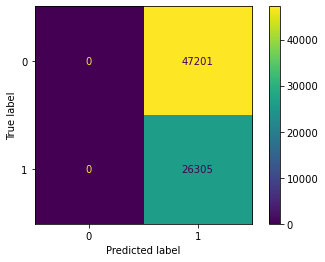

In [4]:
naive = [1]*len(y_test)
naive_cm = metrics.confusion_matrix(y_test, naive)

acc = metrics.accuracy_score(y_test, naive)
bal_acc = metrics.balanced_accuracy_score(y_test, naive)
precision = metrics.precision_score(y_test, naive, pos_label = 1)
recall = metrics.recall_score(y_test, naive, pos_label = 1)

print('Baseline score using Naive Classifier (all predictions are 1)')
print(f'Accuracy: {acc:.4f}')
print(f'Balanced Accuracy: {bal_acc:.4f}')
print(f'Precision score for yes: {precision:.4f}')
print(f'Recall score for yes: {recall:.4f}')

disp = metrics.ConfusionMatrixDisplay(confusion_matrix = naive_cm)
disp.plot()
plt.show()

A naive classifier was used to understand the baseline prediction accuracy if a model erroneously predicted all cases to be 1. This classifier should have a low accuracy score as not all or even most cases are of class 1. This is useful for understanding that a 99% accuracy does not necessarily translate to a great model. For example, if 99% of the cases in a dataset were class 1, naively predicting all cases to be 1 would provide an accurcay score of 99%. However, this model would've failed to correctly predict the relevant 1% of cases. With this naive classifier, we can compare just how much of an improvement the next classifiers provide.

In [5]:
def score_model(model, prediction, model_name = None):
    acc = metrics.accuracy_score(y_test, prediction)
    bal_acc = metrics.balanced_accuracy_score(y_test, prediction)
    precision = metrics.precision_score(y_test, prediction, pos_label = 1)
    recall = metrics.recall_score(y_test, prediction, pos_label = 1)
    
    print(f'Accuracy: {acc:.4f}')
    print(f'Balanced Accuracy: {bal_acc:.4f}')
    print(f'Precision score for yes: {precision:.4f}')
    print(f'Recall score for yes: {recall:.4f}')
    
    class_labels = model.classes_.astype(str)
    

    print(metrics.classification_report(y_test, prediction))
    
    metrics.plot_confusion_matrix(model, X_test, y_test, display_labels = class_labels, values_format = 'd')
    
    if model_name is not None:
        plt.title(f'{model_name} Confusion Matrix')
        plt.savefig(f'figures/{model_name.replace(" ","")}_confmatrix.png', dpi = 300)
      
    plt.show()
    
    return [acc, bal_acc, precision, recall]

In [6]:
def tune_model(model, param_grid):
    model_randomsearch = RandomizedSearchCV(model, param_grid, cv = 5, random_state = SEED)
    
    model_randomsearch.fit(X_train, y_train.values.ravel())
    
    print(f'Optimal hyperparameters: {model_randomsearch.best_params_}')
    
    tuned_pred = model_randomsearch.predict(X_test)
    
    return model_randomsearch, tuned_pred

### 1. Decision Tree Classifier

Baseline Decision Tree Model
Accuracy: 0.6586
Balanced Accuracy: 0.5956
Precision score for yes: 0.5328
Recall score for yes: 0.3739
              precision    recall  f1-score   support

           0       0.70      0.82      0.75     47201
           1       0.53      0.37      0.44     26305

    accuracy                           0.66     73506
   macro avg       0.62      0.60      0.60     73506
weighted avg       0.64      0.66      0.64     73506



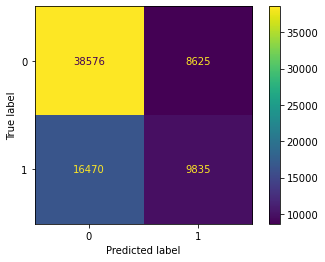

In [7]:
baseline = tree.DecisionTreeClassifier(criterion = 'entropy', random_state = SEED)
baseline.fit(X_train, y_train)

baseline_pred = baseline.predict(X_test)

print("Baseline Decision Tree Model")
base_tree_metrics = score_model(baseline, baseline_pred)

From the baseline Decision Tree model, we significantly improve the predicting power compared to the Naive Classifier. For this project, it would be wise to minimize the amount of false positive errors as false positives would lead to users feeling like they've been misled if they donate to a project that is predicted to meet the donation goal but end up not actually doing so. By looking at the precision ($\frac{True Positive}{True Positive + False Positive}$), we can see whether we are minimizing our false positive classifications. For this Decision Tree model, the precision was 0.5327; a significant improvement from the Naive Classifier, but could use a little more improvement. Hopefully with hyperparameter tuning, we can improve on this model a little bit. 

### 1a. Hyperparameter Tuning for Decision Tree

Optimal hyperparameters: {'max_features': 2, 'max_depth': 20, 'criterion': 'entropy'}
Hyperparameter Tuned Decision Tree Model
Accuracy: 0.6758
Balanced Accuracy: 0.6079
Precision score for yes: 0.5730
Recall score for yes: 0.3692
              precision    recall  f1-score   support

           0       0.71      0.85      0.77     47201
           1       0.57      0.37      0.45     26305

    accuracy                           0.68     73506
   macro avg       0.64      0.61      0.61     73506
weighted avg       0.66      0.68      0.66     73506



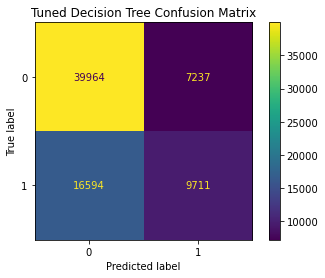

In [8]:
params = {'max_depth': [10,20,30,40, None],
          'criterion': ['gini', 'entropy'],
          'max_features': np.arange(1,10)}

clf = tree.DecisionTreeClassifier(random_state = SEED)

tree_tuned, tree_tuned_pred = tune_model(clf, params)

print('Hyperparameter Tuned Decision Tree Model')
tree_tuned_metrics = score_model(tree_tuned, tree_tuned_pred, 'Tuned Decision Tree')

As can be seen from the results displayed above, hyperparameter tuning provided a slight improvement in the model's predicting power. Accuracry, balanced accuracy, and most importantly, precision score have increased with only the recall score suffering slightly. This was expected as hyperparameter tuning returns a more optimal model based on the dataset. Although this is a good starting point, further improvements can be made to the predicting power. A Random Forest classifier is a more robust model as it simply consists of a vast number of individual Decision Trees working together to make the final predictions. 

### 2. Random Forest Classifier

Base Random Forest Model
Accuracy: 0.6609
Balanced Accuracy: 0.6030
Precision score for yes: 0.5350
Recall score for yes: 0.3994
              precision    recall  f1-score   support

           0       0.71      0.81      0.75     47201
           1       0.54      0.40      0.46     26305

    accuracy                           0.66     73506
   macro avg       0.62      0.60      0.61     73506
weighted avg       0.65      0.66      0.65     73506



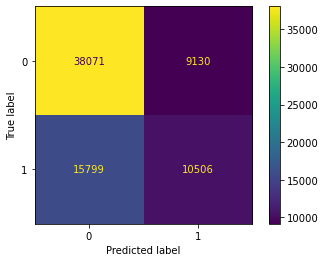

In [9]:
from sklearn.ensemble import RandomForestClassifier

base_forest = RandomForestClassifier(n_estimators = 300, n_jobs = -1, random_state = SEED)
base_forest.fit(X_train, y_train.values.ravel())

base_forest_pred = base_forest.predict(X_test)

print('Base Random Forest Model')
base_forest_metrics = score_model(base_forest, base_forest_pred)

### 2a. Hyperparameter Tuning for Random Forest Classifier

Optimal hyperparameters: {'n_estimators': 350, 'max_samples': 0.30000000000000004, 'max_features': 'log2', 'max_depth': 20}
Hyperparameter Tuned Random Forest Classifier
Accuracy: 0.6872
Balanced Accuracy: 0.6128
Precision score for yes: 0.6091
Recall score for yes: 0.3511
              precision    recall  f1-score   support

           0       0.71      0.87      0.78     47201
           1       0.61      0.35      0.45     26305

    accuracy                           0.69     73506
   macro avg       0.66      0.61      0.61     73506
weighted avg       0.67      0.69      0.66     73506



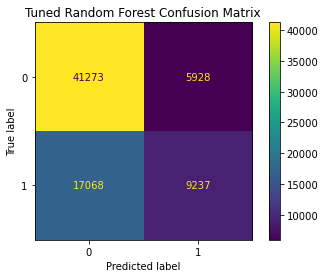

In [10]:
params = {'max_depth': np.arange(10,60,10),
          'n_estimators': np.arange(10,600,10),
          'max_samples': np.arange(0.1,0.4,0.1),
          'max_features': ['sqrt', 'log2']}

forest = RandomForestClassifier(n_jobs = -1, random_state = SEED)

forest_tuned, forest_tuned_pred = tune_model(forest, params)

print('Hyperparameter Tuned Random Forest Classifier')
forest_tuned_metrics = score_model(forest_tuned, forest_tuned_pred, 'Tuned Random Forest')

With the hyperparameter tuned Random Forest classifier, there is a slight improvement in predicting power over the single Decision Tree classifier. All four reported metrics have slightly improved even though there is a slight increase in the number of false positive predictions. However, there are significantly less false negative predictions and more true positive predictions. When comparing the two models, the Random Forest classifier definitely outperforms the Decision Tree classifier, albeit only slightly. The next model to be tested will be the Gradient Boosting classifier. Similar to the Random Forest classifier, the Gradient Boosting classifier uses an ensemble of decision trees to make its predictions; however the main difference is that Random Forest uses fully grown decision trees (low bias, high variance), while Gradient Boosting uses shallow trees (high bias, low variance).

### 3. Gradient Boosting Classifier

Accuracy: 0.6856
Balanced Accuracy: 0.6064
Precision score for yes: 0.6137
Recall score for yes: 0.3277
              precision    recall  f1-score   support

           0       0.70      0.89      0.78     47201
           1       0.61      0.33      0.43     26305

    accuracy                           0.69     73506
   macro avg       0.66      0.61      0.61     73506
weighted avg       0.67      0.69      0.66     73506



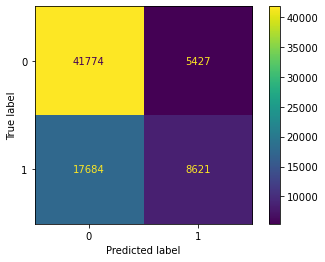

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

base_gbm = GradientBoostingClassifier(random_state = SEED)
base_gbm.fit(X_train, y_train.values.ravel())

base_gbm_pred = base_gbm.predict(X_test)

base_gbm_metrics = score_model(base_gbm, base_gbm_pred)

### 3a. Hyperparameter Tuning for Gradient Boosting Classifier

Optimal hyperparameters: {'n_estimators': 60, 'learning_rate': 0.2}
Hyperparameter Tuned Gradient Boosting Classifier
Accuracy: 0.6865
Balanced Accuracy: 0.6099
Precision score for yes: 0.6113
Recall score for yes: 0.3406
              precision    recall  f1-score   support

           0       0.71      0.88      0.78     47201
           1       0.61      0.34      0.44     26305

    accuracy                           0.69     73506
   macro avg       0.66      0.61      0.61     73506
weighted avg       0.67      0.69      0.66     73506



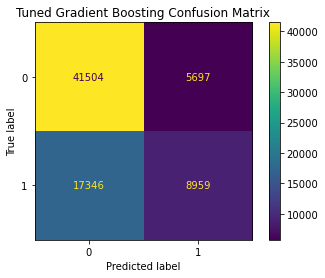

In [12]:
params = {'learning_rate': np.arange(0.05,0.2,0.05),
          'n_estimators': np.arange(20,81,10)}

gbm = GradientBoostingClassifier(random_state = SEED)

gbm_tuned, gbm_tuned_pred = tune_model(gbm, params)

print('Hyperparameter Tuned Gradient Boosting Classifier')
gbm_tuned_metrics = score_model(gbm_tuned, gbm_tuned_pred, 'Tuned Gradient Boosting')

The Gradient Boosting classifier model definitely outperforms the previous two models used. The accuracy and precision score has improved from the Random Forest classifier, with a slight decrease in balanced accuracy and recall score. Although there was a slight decrease in those two metrics, because the precision score is the most important metrics for this project, the hypertuned Gradient Boosting classifier has performed better than the Random Forest model. 

### 4. K-Nearest Neighbors Classifier

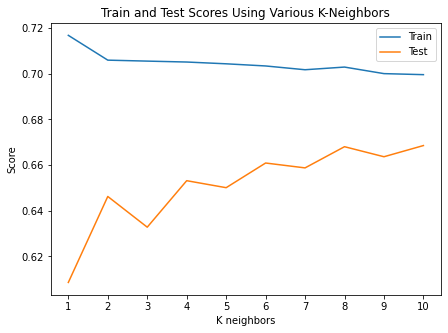

In [13]:
from sklearn.neighbors import KNeighborsClassifier

train_scores = []
test_scores = []

for i in range(1,11):
    knn = KNeighborsClassifier(i)
    knn.fit(X_train, y_train.values.ravel())
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))
    
plt.figure(figsize = (7,5))
plt.plot(range(1,11), train_scores, label = 'Train')
plt.plot(range(1,11), test_scores, label = 'Test')
plt.xticks(range(1,11))
plt.xlabel('K neighbors')
plt.ylabel('Score')
plt.title('Train and Test Scores Using Various K-Neighbors')
plt.legend()
plt.savefig('figures/knn_elbow.png')
plt.show()

K-Nearest Neighbors Classifier
Accuracy: 0.6686
Balanced Accuracy: 0.5963
Precision score for yes: 0.5605
Recall score for yes: 0.3419
              precision    recall  f1-score   support

           0       0.70      0.85      0.77     47201
           1       0.56      0.34      0.42     26305

    accuracy                           0.67     73506
   macro avg       0.63      0.60      0.60     73506
weighted avg       0.65      0.67      0.64     73506



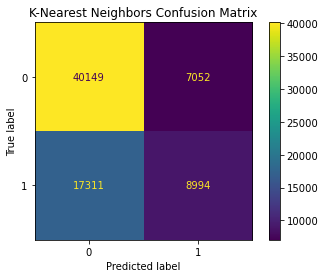

In [14]:
knn = KNeighborsClassifier(10)
knn.fit(X_train, y_train.values.ravel())

knn_pred = knn.predict(X_test)

print('K-Nearest Neighbors Classifier')
knn_metrics = score_model(knn, knn_pred, 'K-Nearest Neighbors')

The K-Nearest Neighbors classifier performed the worst out of all four models tested. Not only did the four metrics decrease, it also had one of the highest amount of total misclassified predictions.

### 5. Model Comparisons

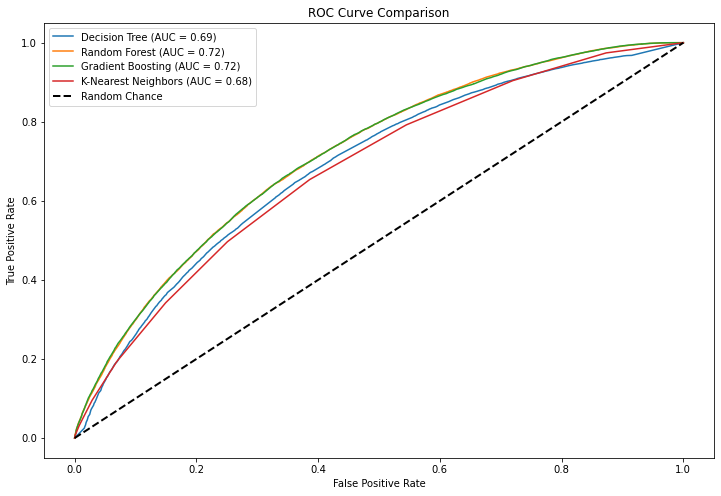

In [15]:
plt.figure(figsize = (12,8))
ax = plt.gca()
tree_roc = metrics.plot_roc_curve(tree_tuned, X_test, y_test, ax = ax, name = 'Decision Tree')
forest_roc = metrics.plot_roc_curve(forest_tuned, X_test, y_test, ax = ax, name = 'Random Forest')
gbm_roc = metrics.plot_roc_curve(gbm_tuned, X_test, y_test, ax = ax, name = 'Gradient Boosting')
knn_roc = metrics.plot_roc_curve(knn, X_test, y_test, ax = ax, name = 'K-Nearest Neighbors')
ax.plot([0,1], [0,1], linestyle = '--', label = 'Random Chance', color = 'black', linewidth = 2)
ax.set_title('ROC Curve Comparison')
ax.legend()
plt.savefig('figures/roc_curves.png', dpi = 300)
plt.show()

In [16]:
all_metrics = pd.DataFrame({'Decision Tree': tree_tuned_metrics,
                            'Random Forest': forest_tuned_metrics,
                            'Gradient Boosting': gbm_tuned_metrics,
                            'KNN': knn_metrics}, index = ['Accuracy', 'Balanced Accuracy', 'Precision', 'Recall'])
all_metrics

,Decision Tree,Random Forest,Gradient Boosting,KNN
Accuracy,0.675795,0.687155,0.686515,0.668558
Balanced Accuracy,0.607923,0.612780,0.609943,0.596254
Precision,0.572988,0.609100,0.611285,0.560514
Recall,0.369169,0.351150,0.340582,0.341912


From the ROC (Receiver Operator Characteristic) curve above, it can be seen that the Gradient Boosting classifier is our best performing model. The ROC curve is used to display the trade-off between sensitivity and specificity of classifiers. When comparing models using the ROC curve, models whose curves are closer to the top left corner perform better; while models that are close to the baseline of random chance are performing more poorly. From the plot above, it can be seen that the Gradient Boosting classifier's ROC curve is closest to the top left corner with the Random Forest performing only slightly worse. Along with the ROC curve, the Gradient Boosting classifier also has the highest accuracy and recall score. As stated before, the recall score is the most important metric for this project as it aims to minimize the amount of false positive predictions. Because of these reasons, the Gradient Booster is chosen to be used to predict whether a Kickstarter project will be successfully backed. 

